cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.76e+00 | test_loss: 8.54e+00 | reg: 6.30e+00 | : 100%|█| 100/100 [00:02<00:00, 42.47


saving model version 0.1
MAE: 6.6038
MSE: 72.9550
MAPE: 6.4560
R²: 0.4471
RMSE: 8.5414
fixing (0,0,0) with 1/x, r2=1.0000005960464478, c=2
fixing (0,1,0) with 0, r2=0.0, c=0
fixing (0,2,0) with cos, r2=1.0000001192092896, c=2
saving model version 0.2


0.714*cos(8.712*x_3 + 8.928) + 104.684 + 3.009/(2.886 - 5.151*x_1)

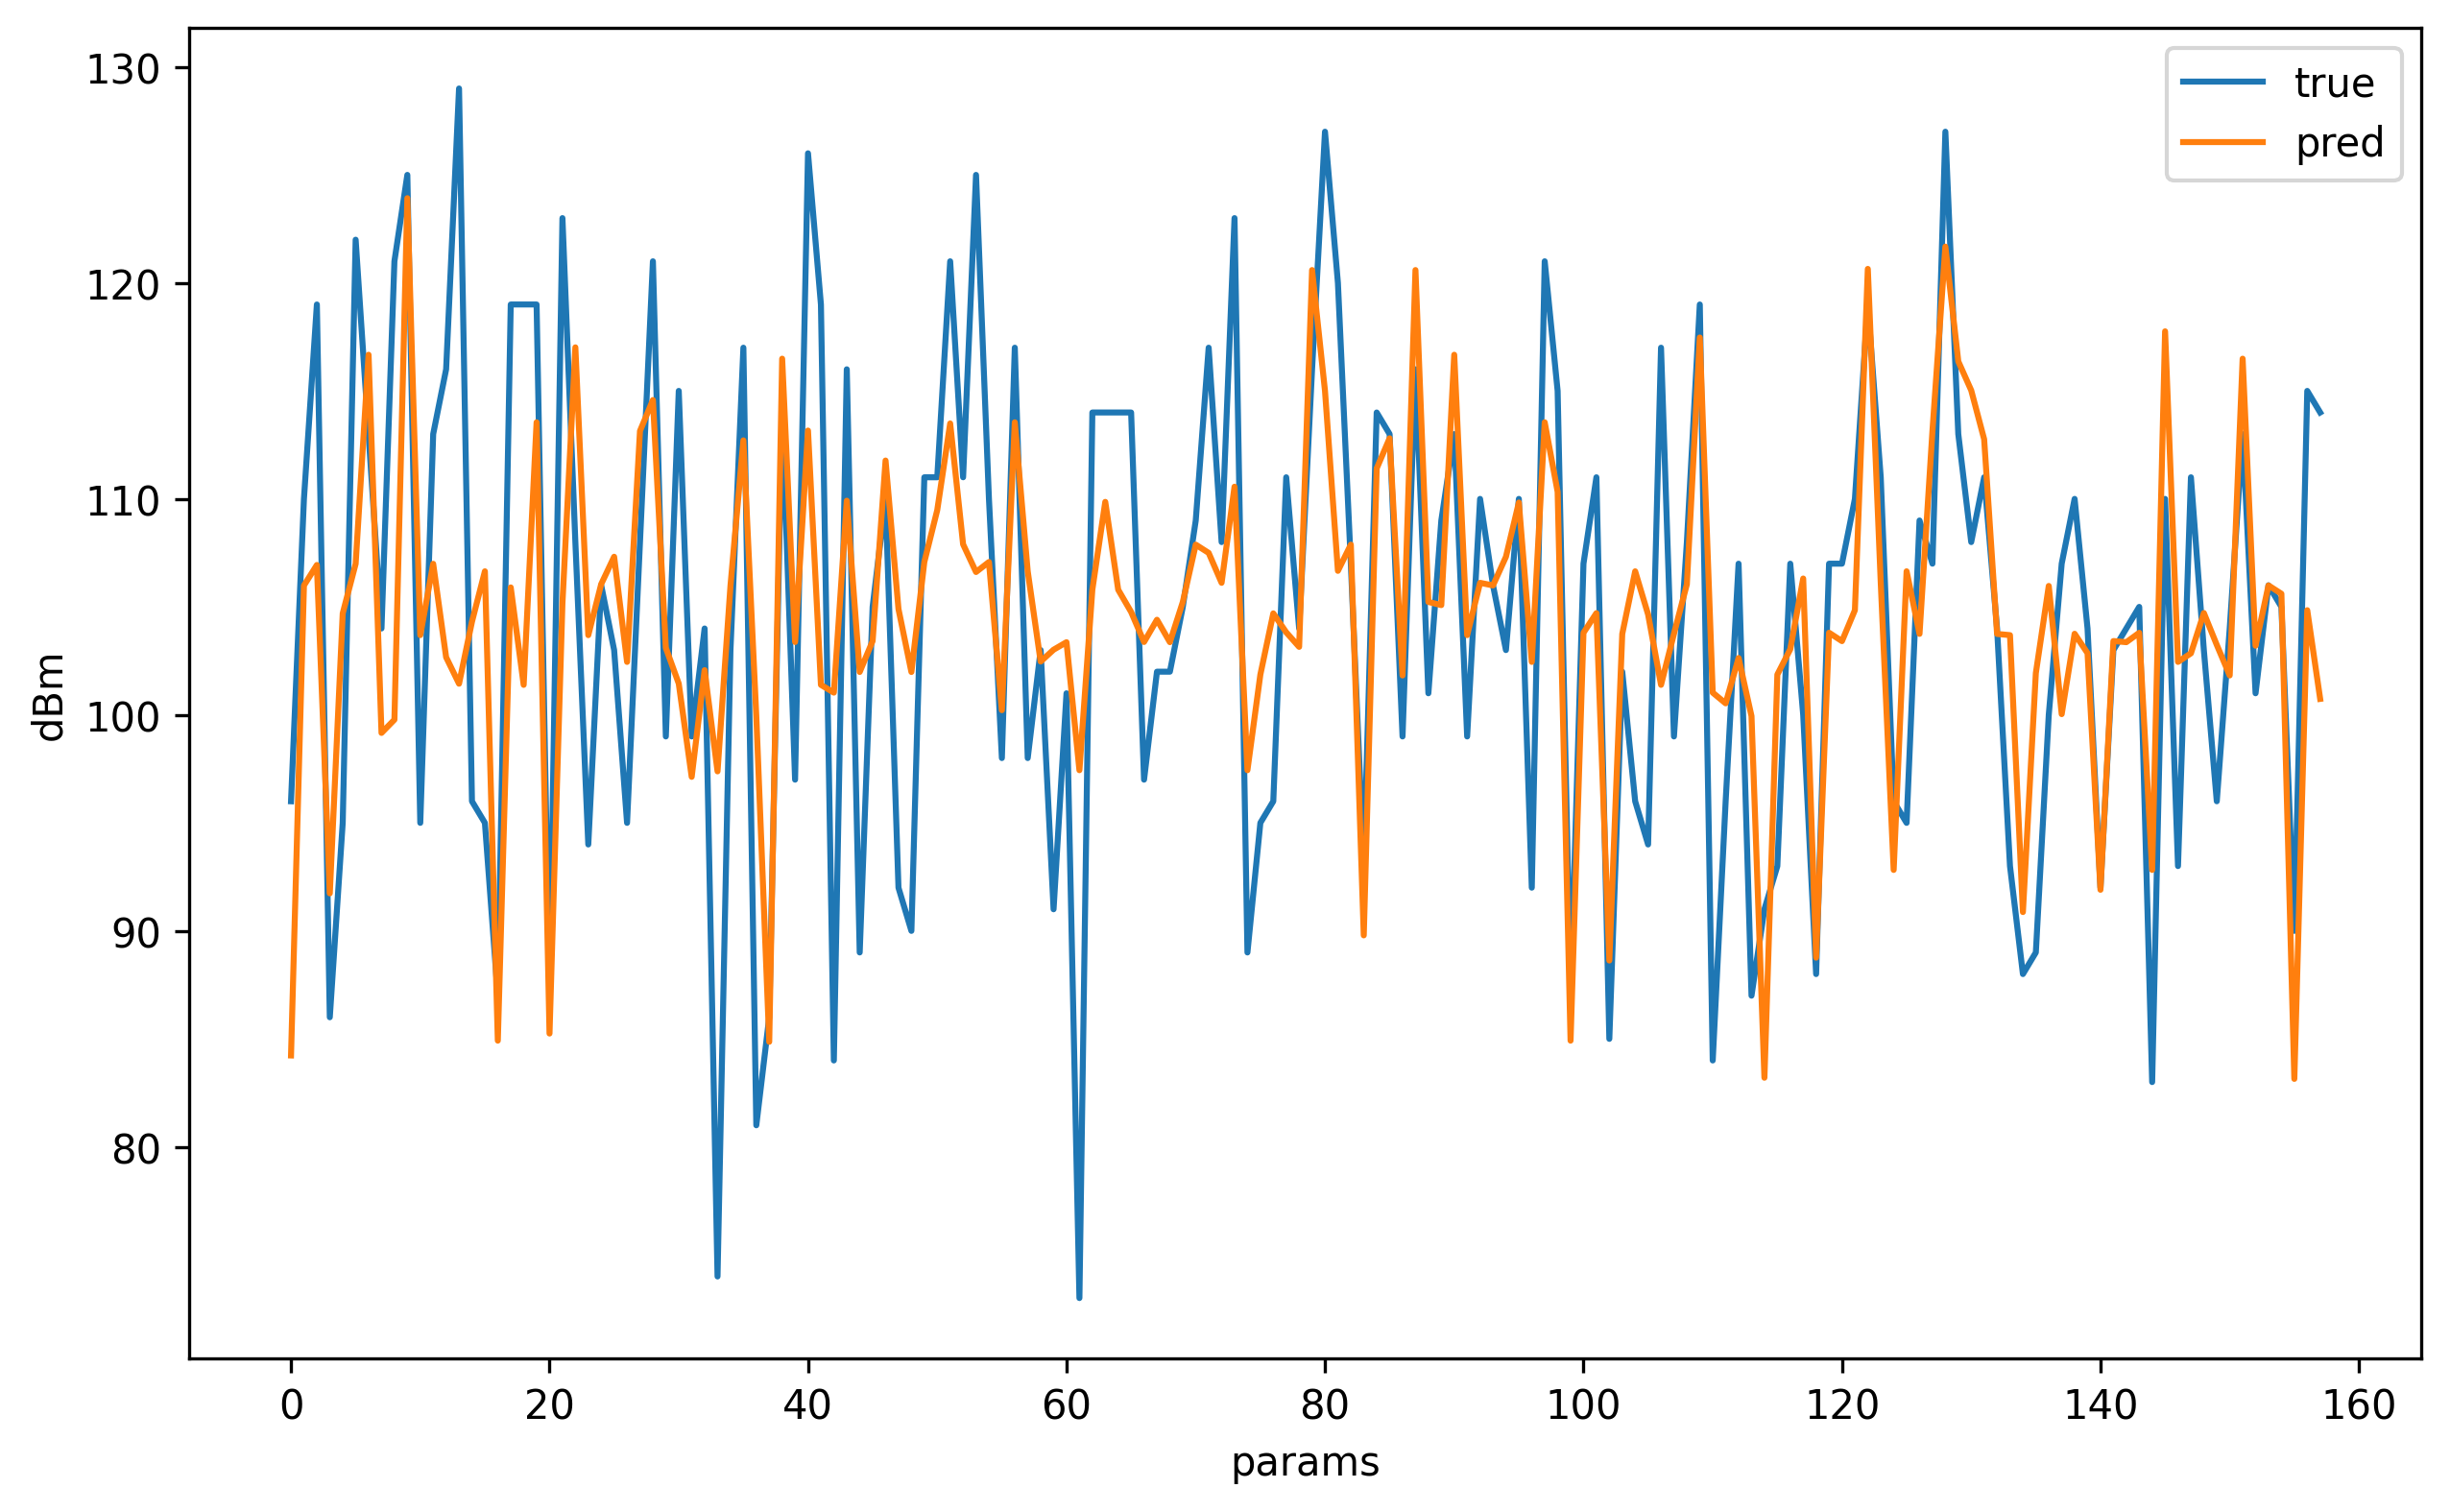

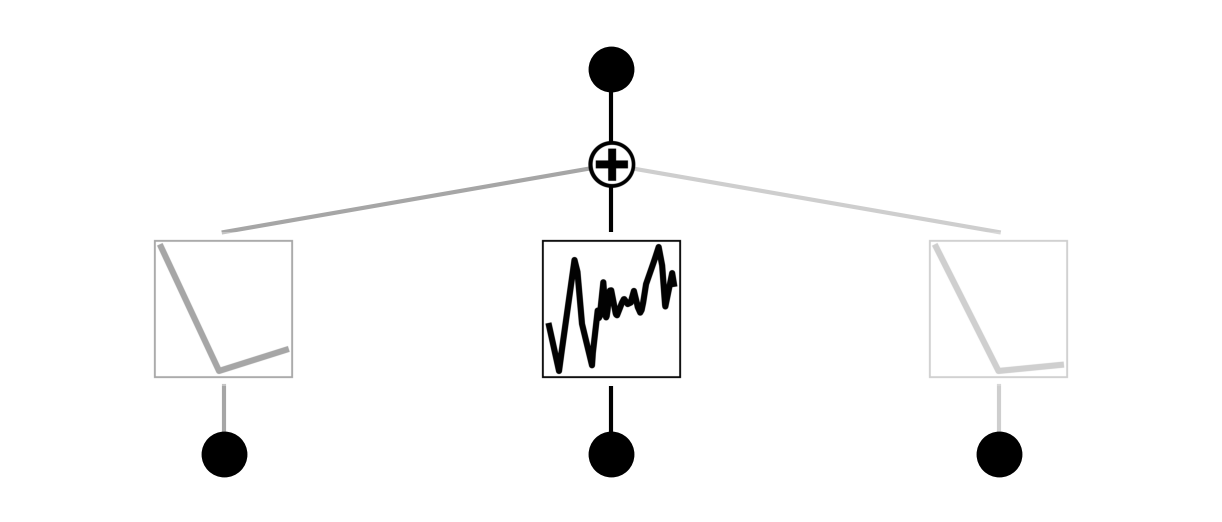

In [ ]:

from kan import *
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def eval_kan(model_kan, test_data):
    y_true = test_data['test_label']
    with torch.no_grad():
        y_pred = model_kan(test_data['test_input'])
        
    y_true = y_true.detach().cpu().numpy().ravel()
    y_pred = y_pred.detach().cpu().numpy().ravel()
    time = range(len(y_true))

    # Plot the training and test losses.
    plt.plot(time, y_true)
    plt.plot(time, y_pred)
    plt.legend(['true', 'pred'])
    plt.ylabel('dBm')
    plt.xlabel('params')


    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    mape_frac = mean_absolute_percentage_error(y_true, y_pred)
    mape = mape_frac * 100
    
    # Print results
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return mse, rmse, mae, mape, r2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_gids_steps_lambda_loss(gids_size, steps, lam, metric, metric_name):
    """
    Plots a 3D scatter of gids_size vs steps vs train_loss, 
    with point color representing lambda.
    
    Parameters:
    - gids_size: array-like of shape (N,)
    - steps: array-like of shape (N,)
    - lam: array-like of shape (N,)
    - train_loss: array-like of shape (N,)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(gids_size, steps, lam, c=metric)
    
    ax.set_xlabel('gids size')
    ax.set_ylabel('steps')
    ax.set_zlabel('lambda')
    
    plt.colorbar(sc, label='metric')
    plt.title('3D Scatter: gids size vs steps vs lambda (' + metric_name + ' as color)')
    plt.show()


# Read the data from the Excel file
indoor_data = pd.read_excel('csv_experiments.xlsx', sheet_name='Outdoor', header=0)

# Assuming `inputs` and `labels` are your raw data as numpy arrays
inputs = indoor_data[['hed', 'd', 'f']].values  # Input features (f and d)
labels = indoor_data['PL'].values    # Output labels 
train_input, test_input, train_label, test_label = train_test_split(
    inputs, labels, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
train_input = torch.tensor(train_input, dtype=torch.float32)
test_input = torch.tensor(test_input, dtype=torch.float32)

train_label = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1)
test_label = torch.tensor(test_label, dtype=torch.float32).unsqueeze(1)

# Prepare the dataset dictionary
dataset = {}
dataset['train_input'] = train_input
dataset['test_input'] = test_input
dataset['train_label'] = train_label
dataset['test_label'] = test_label

model = KAN(width=[3,1], grid=20, k=3, seed=42, device=device)

model.fit(dataset, opt="LBFGS", steps=100, lamb=0.02, lamb_entropy=2.);

eval_kan(model, dataset)
model.plot()

lib = ['x', 'log', 'sqrt', 'abs']
model.auto_symbolic(lib=lib)

ex_round(model.symbolic_formula()[0][0], 3)



| train_loss: 1.08e+01 | test_loss: 1.15e+01 | reg: 0.00e+00 | : 100%|█| 100/100 [00:02<00:00, 41.57


saving model version 0.3
MSE: 132.2998
RMSE: 11.5022
MAE: 9.3969
MAPE: 9.3010
R²: -0.0026


11893*sin(51483*x_1/10000 + 38957/10000)/10000 - 1157*cos(37893*x_3/5000 + 7117/5000)/1000 + 52607/500

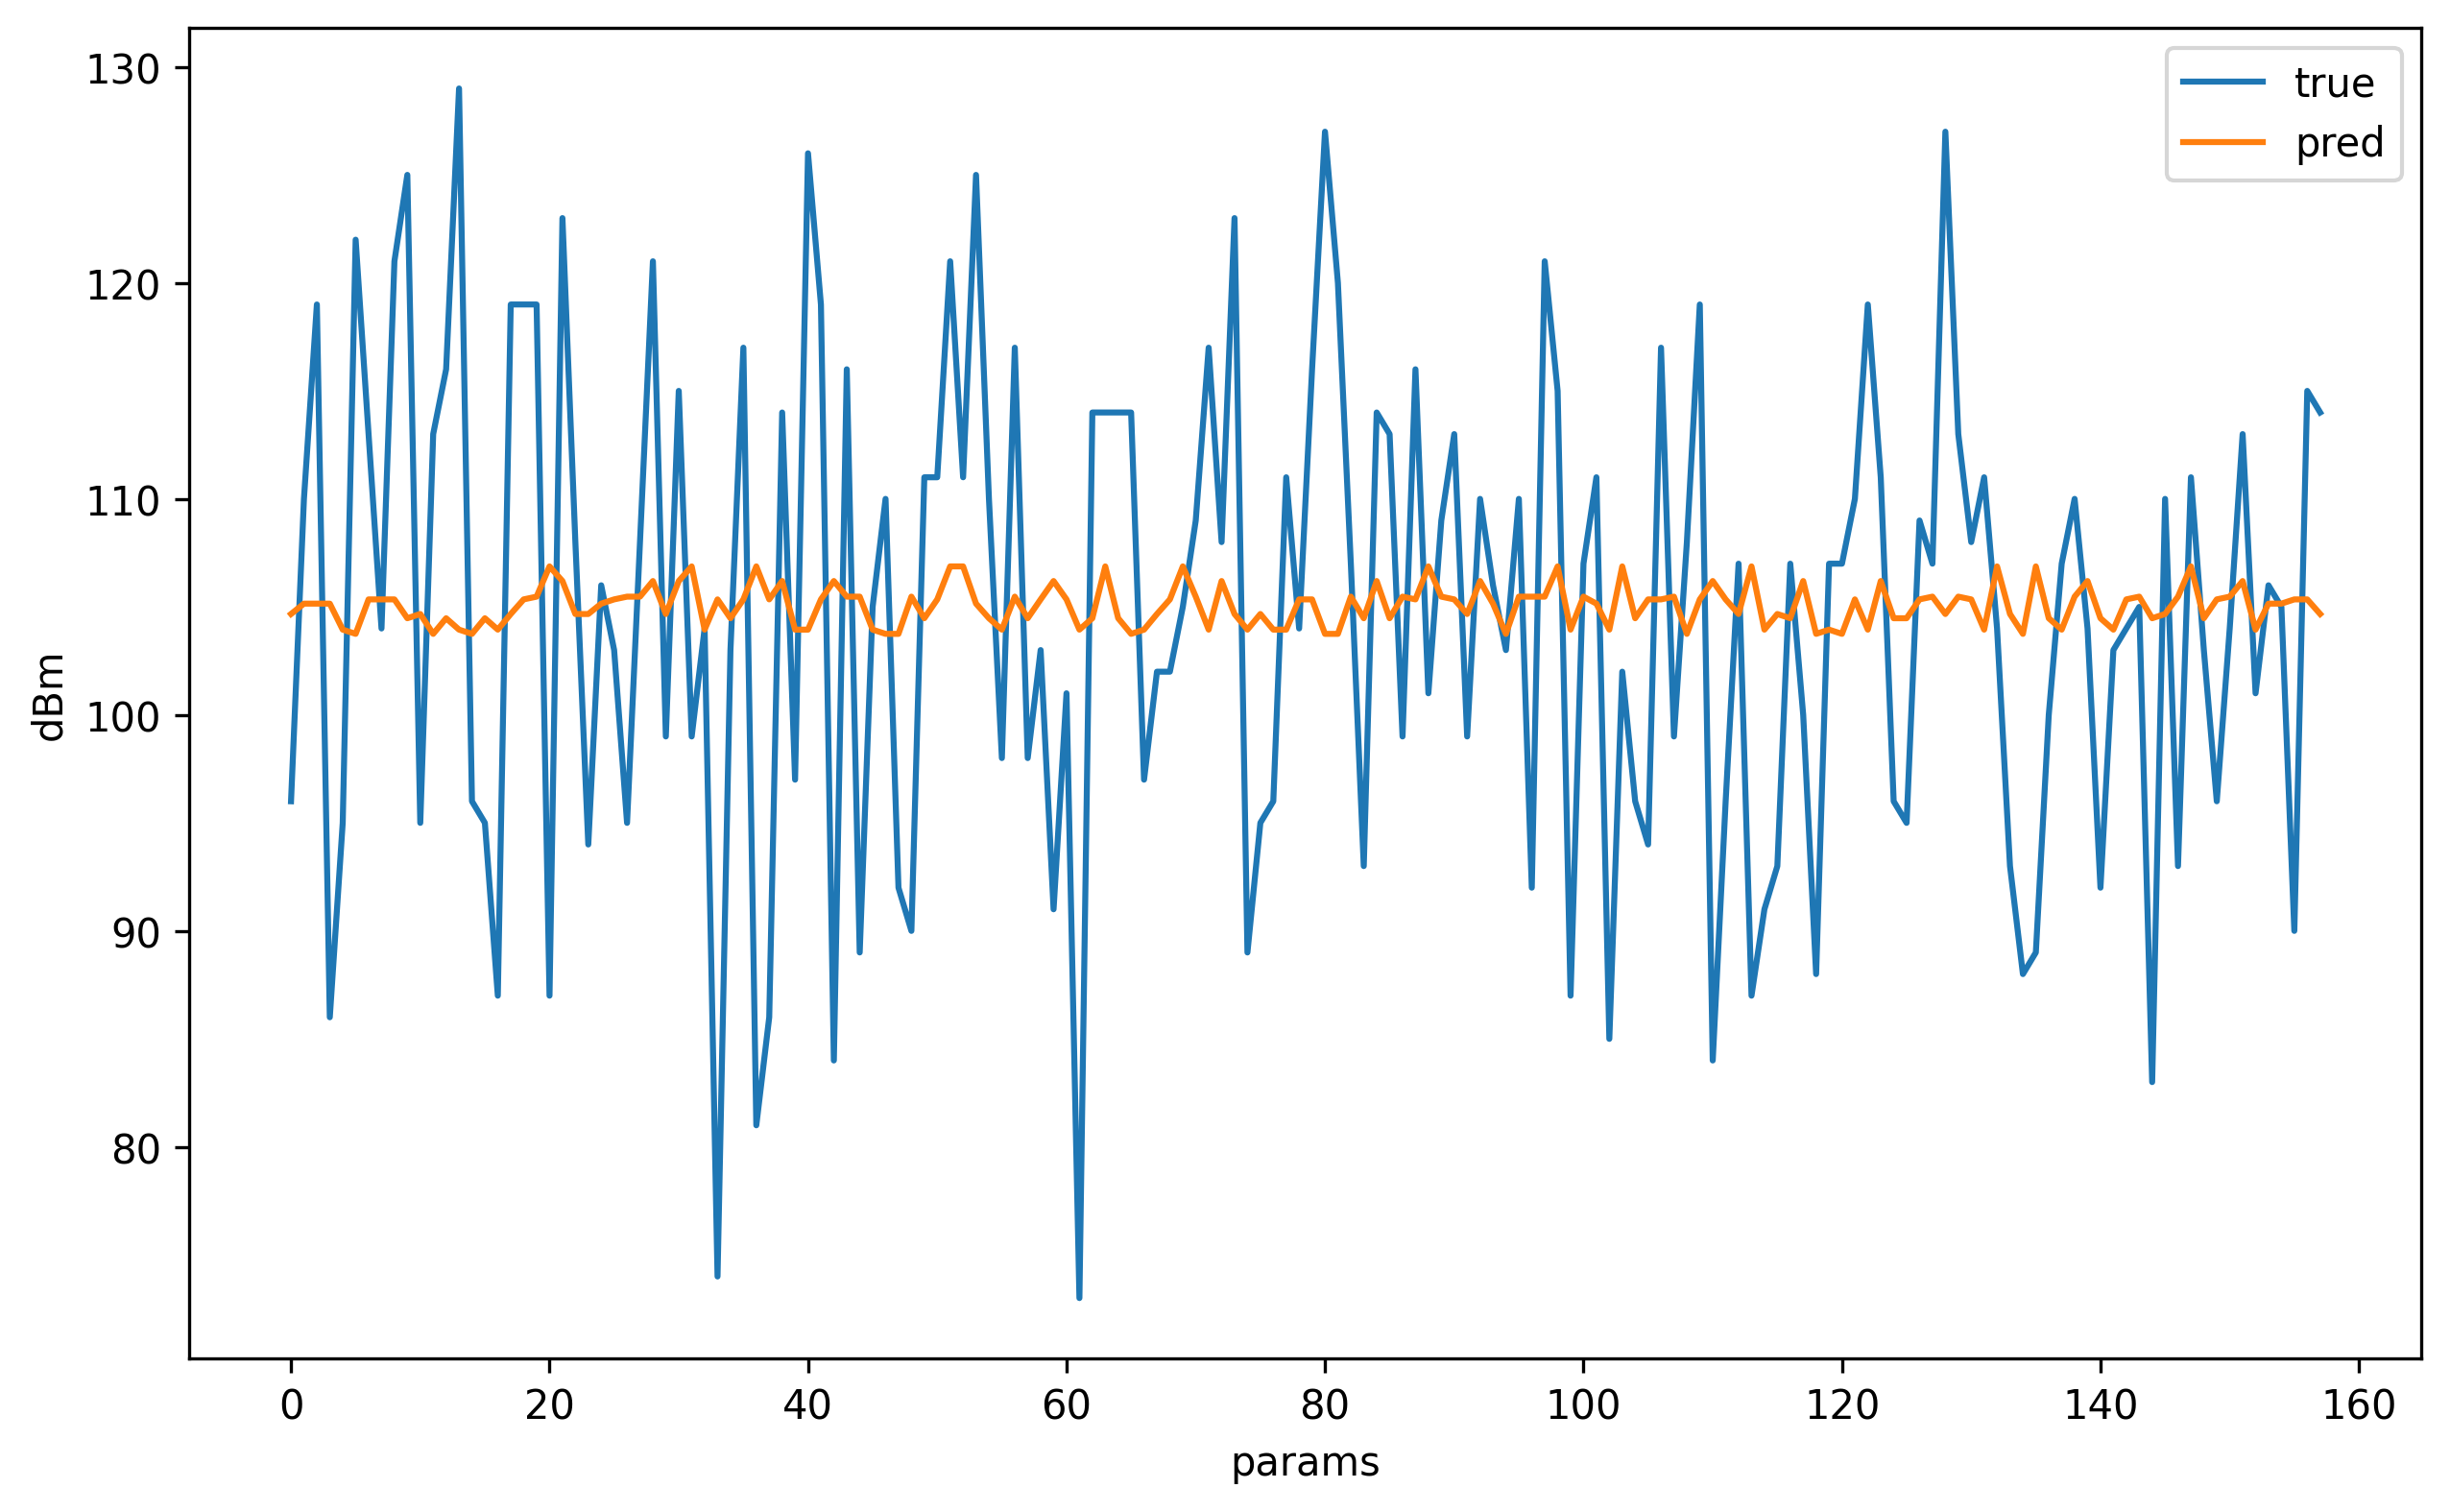

In [10]:
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.0002, lamb_entropy=2.);
eval_kan(model, dataset)

formula = model.symbolic_formula()[0][0]
nsimplify(ex_round(formula, 4))

checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.02


| train_loss: 9.29e+00 | test_loss: 1.02e+01 | reg: 1.20e+01 | : 100%|█| 100/100 [00:04<00:00, 23.01


saving model version 0.1
MAE: 8.2743
MSE: 104.7763
MAPE: 8.1054
R²: 0.2059
RMSE: 10.2360
[np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.002


| train_loss: 9.09e+00 | test_loss: 1.03e+01 | reg: 4.41e+01 | : 100%|█| 100/100 [00:05<00:00, 19.17


saving model version 0.1
MAE: 8.1221
MSE: 105.7995
MAPE: 7.9388
R²: 0.1982
RMSE: 10.2859
[np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.0002


| train_loss: 9.38e+00 | test_loss: 1.04e+01 | reg: 1.64e+01 | : 100%|█| 100/100 [00:04<00:00, 24.65


saving model version 0.1
MAE: 8.3059
MSE: 107.5525
MAPE: 8.1341
R²: 0.1849
RMSE: 10.3708
[np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 2e-05


| train_loss: 9.13e+00 | test_loss: 1.02e+01 | reg: 3.02e+01 | : 100%|█| 100/100 [00:04<00:00, 20.50


saving model version 0.1
MAE: 8.0701
MSE: 104.5229
MAPE: 7.8718
R²: 0.2079
RMSE: 10.2236
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.02


| train_loss: 9.03e+00 | test_loss: 1.01e+01 | reg: 1.29e+01 | : 100%|█| 200/200 [00:06<00:00, 29.42


saving model version 0.1
MAE: 8.0204
MSE: 101.4864
MAPE: 7.8369
R²: 0.2309
RMSE: 10.0740
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.002


| train_loss: 8.33e+00 | test_loss: 9.21e+00 | reg: 3.08e+01 | : 100%|█| 200/200 [00:11<00:00, 17.20


saving model version 0.1
MAE: 7.1084
MSE: 84.7766
MAPE: 6.9517
R²: 0.3575
RMSE: 9.2074
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.0002


| train_loss: 9.30e+00 | test_loss: 1.05e+01 | reg: 1.66e+01 | : 100%|█| 200/200 [00:07<00:00, 27.34


saving model version 0.1
MAE: 8.3104
MSE: 109.9082
MAPE: 8.1771
R²: 0.1671
RMSE: 10.4837
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 2e-05


| train_loss: 9.09e+00 | test_loss: 1.03e+01 | reg: 3.66e+01 | : 100%|█| 200/200 [00:08<00:00, 22.69


saving model version 0.1
MAE: 8.1025
MSE: 105.2761
MAPE: 7.9124
R²: 0.2022
RMSE: 10.2604
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.02


| train_loss: 9.03e+00 | test_loss: 1.01e+01 | reg: 1.29e+01 | : 100%|█| 300/300 [00:08<00:00, 33.66


saving model version 0.1
MAE: 8.0204
MSE: 101.4864
MAPE: 7.8369
R²: 0.2309
RMSE: 10.0740
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.002


| train_loss: 8.14e+00 | test_loss: 9.03e+00 | reg: 2.49e+01 | : 100%|█| 300/300 [00:15<00:00, 19.09


saving model version 0.1
MAE: 6.9808
MSE: 81.5240
MAPE: 6.8291
R²: 0.3822
RMSE: 9.0291
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.0002


| train_loss: 9.06e+00 | test_loss: 1.04e+01 | reg: 2.78e+01 | : 100%|█| 300/300 [00:11<00:00, 26.51


saving model version 0.1
MAE: 8.2597
MSE: 108.0237
MAPE: 8.0901
R²: 0.1813
RMSE: 10.3934
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 2e-05


| train_loss: 9.02e+00 | test_loss: 1.02e+01 | reg: 3.24e+01 | : 100%|█| 300/300 [00:11<00:00, 25.46


saving model version 0.1
MAE: 8.0413
MSE: 103.5430
MAPE: 7.8462
R²: 0.2153
RMSE: 10.1756
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.02


| train_loss: 9.35e+00 | test_loss: 1.07e+01 | reg: 1.48e+01 | : 100%|█| 100/100 [00:03<00:00, 26.47


saving model version 0.1
MAE: 8.4496
MSE: 113.5475
MAPE: 8.3096
R²: 0.1395
RMSE: 10.6559
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.002


| train_loss: 9.24e+00 | test_loss: 1.04e+01 | reg: 1.31e+01 | : 100%|█| 100/100 [00:03<00:00, 28.13


saving model version 0.1
MAE: 8.4829
MSE: 108.2860
MAPE: 8.3066
R²: 0.1793
RMSE: 10.4061
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.0002


| train_loss: 9.24e+00 | test_loss: 1.04e+01 | reg: 1.21e+01 | : 100%|█| 100/100 [00:03<00:00, 25.14


saving model version 0.1
MAE: 8.4625
MSE: 108.8235
MAPE: 8.2608
R²: 0.1753
RMSE: 10.4319
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 2e-05


| train_loss: 8.11e+00 | test_loss: 9.10e+00 | reg: 1.08e+01 | : 100%|█| 100/100 [00:07<00:00, 13.52


saving model version 0.1
MAE: 6.9931
MSE: 82.7219
MAPE: 6.8871
R²: 0.3731
RMSE: 9.0952
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.02


| train_loss: 9.35e+00 | test_loss: 1.07e+01 | reg: 1.48e+01 | : 100%|█| 200/200 [00:05<00:00, 35.07


saving model version 0.1
MAE: 8.4496
MSE: 113.5476
MAPE: 8.3096
R²: 0.1395
RMSE: 10.6559
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.002


| train_loss: 9.24e+00 | test_loss: 1.04e+01 | reg: 1.32e+01 | : 100%|█| 200/200 [00:06<00:00, 32.18


saving model version 0.1
MAE: 8.4831
MSE: 108.2621
MAPE: 8.3075
R²: 0.1795
RMSE: 10.4049
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.0002


| train_loss: 9.24e+00 | test_loss: 1.04e+01 | reg: 1.21e+01 | : 100%|█| 200/200 [00:06<00:00, 29.35


saving model version 0.1
MAE: 8.4625
MSE: 108.8235
MAPE: 8.2608
R²: 0.1753
RMSE: 10.4319
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 2e-05


| train_loss: 8.11e+00 | test_loss: 9.09e+00 | reg: 1.08e+01 | : 100%|█| 200/200 [00:09<00:00, 20.62


saving model version 0.1
MAE: 6.9886
MSE: 82.6395
MAPE: 6.8831
R²: 0.3737
RMSE: 9.0906
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.02


| train_loss: 9.35e+00 | test_loss: 1.07e+01 | reg: 1.48e+01 | : 100%|█| 300/300 [00:07<00:00, 38.52


saving model version 0.1
MAE: 8.4496
MSE: 113.5476
MAPE: 8.3096
R²: 0.1395
RMSE: 10.6559
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.002


| train_loss: 9.24e+00 | test_loss: 1.04e+01 | reg: 1.32e+01 | : 100%|█| 300/300 [00:08<00:00, 34.47


saving model version 0.1
MAE: 8.4831
MSE: 108.2621
MAPE: 8.3075
R²: 0.1795
RMSE: 10.4049
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.0002


| train_loss: 9.24e+00 | test_loss: 1.04e+01 | reg: 1.21e+01 | : 100%|█| 300/300 [00:10<00:00, 29.37


saving model version 0.1
MAE: 8.4625
MSE: 108.8235
MAPE: 8.2608
R²: 0.1753
RMSE: 10.4319
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 2e-05


| train_loss: 8.09e+00 | test_loss: 9.11e+00 | reg: 1.08e+01 | : 100%|█| 300/300 [00:14<00:00, 21.38


saving model version 0.1
MAE: 7.0243
MSE: 83.0692
MAPE: 6.9147
R²: 0.3705
RMSE: 9.1142
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.02


| train_loss: 9.23e+00 | test_loss: 1.08e+01 | reg: 2.04e+01 | : 100%|█| 100/100 [00:03<00:00, 25.14


saving model version 0.1
MAE: 8.4361
MSE: 116.9286
MAPE: 8.2064
R²: 0.1139
RMSE: 10.8134
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.002


| train_loss: 8.20e+00 | test_loss: 9.55e+00 | reg: 1.01e+01 | : 100%|█| 100/100 [00:07<00:00, 14.00


saving model version 0.1
MAE: 7.2093
MSE: 91.2808
MAPE: 7.1205
R²: 0.3082
RMSE: 9.5541
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.0002


| train_loss: 9.11e+00 | test_loss: 1.04e+01 | reg: 1.14e+01 | : 100%|█| 100/100 [00:05<00:00, 17.39


saving model version 0.1
MAE: 8.3934
MSE: 107.8655
MAPE: 8.2012
R²: 0.1825
RMSE: 10.3858
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 2e-05


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [00:12<00:00,  8.30it/s]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.02


| train_loss: 9.23e+00 | test_loss: 1.08e+01 | reg: 2.04e+01 | : 100%|█| 200/200 [00:08<00:00, 24.34


saving model version 0.1
MAE: 8.4361
MSE: 116.9286
MAPE: 8.2064
R²: 0.1139
RMSE: 10.8134
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.002


| train_loss: 7.95e+00 | test_loss: 9.03e+00 | reg: 1.12e+01 | : 100%|█| 200/200 [00:15<00:00, 12.59


saving model version 0.1
MAE: 7.0829
MSE: 81.5847
MAPE: 6.9324
R²: 0.3817
RMSE: 9.0324
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.0002


| train_loss: 9.11e+00 | test_loss: 1.04e+01 | reg: 1.14e+01 | : 100%|█| 200/200 [00:07<00:00, 25.29


saving model version 0.1
MAE: 8.3933
MSE: 107.8636
MAPE: 8.2012
R²: 0.1826
RMSE: 10.3857
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 2e-05


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [00:18<00:00, 10.68it/s]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.02


| train_loss: 9.23e+00 | test_loss: 1.08e+01 | reg: 2.04e+01 | : 100%|█| 300/300 [00:08<00:00, 36.82


saving model version 0.1
MAE: 8.4361
MSE: 116.9286
MAPE: 8.2064
R²: 0.1139
RMSE: 10.8134
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.002


| train_loss: 7.92e+00 | test_loss: 9.02e+00 | reg: 1.13e+01 | : 100%|█| 300/300 [00:18<00:00, 16.32


saving model version 0.1
MAE: 7.0815
MSE: 81.3642
MAPE: 6.9149
R²: 0.3834
RMSE: 9.0202
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.0002


| train_loss: 9.11e+00 | test_loss: 1.04e+01 | reg: 1.14e+01 | : 100%|█| 300/300 [00:11<00:00, 25.31


saving model version 0.1
MAE: 8.3933
MSE: 107.8636
MAPE: 8.2012
R²: 0.1826
RMSE: 10.3857
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 2e-05


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 300/300 [00:35<00:00,  8.50it/s]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.02


| train_loss: 9.27e+00 | test_loss: 1.05e+01 | reg: 8.37e+00 | : 100%|█| 100/100 [00:03<00:00, 31.65


saving model version 0.1
MAE: 8.4477
MSE: 110.7159
MAPE: 8.2703
R²: 0.1609
RMSE: 10.5222
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.002


| train_loss: 8.34e+00 | test_loss: 9.35e+00 | reg: 8.25e+00 | : 100%|█| 100/100 [00:05<00:00, 19.86


saving model version 0.1
MAE: 7.3520
MSE: 87.4179
MAPE: 7.1469
R²: 0.3375
RMSE: 9.3498
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.0002


| train_loss: 8.85e+00 | test_loss: 1.01e+01 | reg: 9.77e+00 | : 100%|█| 100/100 [00:04<00:00, 22.42


saving model version 0.1
MAE: 8.2192
MSE: 102.9370
MAPE: 8.0218
R²: 0.2199
RMSE: 10.1458
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 2e-05


| train_loss: 9.45e+00 | test_loss: 1.06e+01 | reg: 1.37e+01 | : 100%|█| 100/100 [00:04<00:00, 23.83


saving model version 0.1
MAE: 8.6317
MSE: 112.2401
MAPE: 8.4996
R²: 0.1494
RMSE: 10.5943
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.02


| train_loss: 9.27e+00 | test_loss: 1.05e+01 | reg: 8.37e+00 | : 100%|█| 200/200 [00:05<00:00, 36.03


saving model version 0.1
MAE: 8.4477
MSE: 110.7159
MAPE: 8.2703
R²: 0.1609
RMSE: 10.5222
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.002


| train_loss: 8.34e+00 | test_loss: 9.35e+00 | reg: 8.25e+00 | : 100%|█| 200/200 [00:08<00:00, 24.97


saving model version 0.1
MAE: 7.3511
MSE: 87.4106
MAPE: 7.1457
R²: 0.3376
RMSE: 9.3494
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.0002


| train_loss: 8.85e+00 | test_loss: 1.01e+01 | reg: 9.77e+00 | : 100%|█| 200/200 [00:07<00:00, 26.09


saving model version 0.1
MAE: 8.2192
MSE: 102.9370
MAPE: 8.0218
R²: 0.2199
RMSE: 10.1458
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 2e-05


| train_loss: 9.45e+00 | test_loss: 1.06e+01 | reg: 1.37e+01 | : 100%|█| 200/200 [00:08<00:00, 23.26


saving model version 0.1
MAE: 8.6317
MSE: 112.2401
MAPE: 8.4996
R²: 0.1494
RMSE: 10.5943
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 300, 0.02


| train_loss: 9.27e+00 | test_loss: 1.05e+01 | reg: 8.37e+00 | : 100%|█| 300/300 [00:11<00:00, 26.60


saving model version 0.1
MAE: 8.4477
MSE: 110.7159
MAPE: 8.2703
R²: 0.1609
RMSE: 10.5222
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 300, 0.002


| train_loss: 8.34e+00 | test_loss: 9.35e+00 | reg: 8.25e+00 | : 100%|█| 300/300 [00:21<00:00, 14.25


saving model version 0.1
MAE: 7.3511
MSE: 87.4106
MAPE: 7.1457
R²: 0.3376
RMSE: 9.3494
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 300, 0.0002


| train_loss: 8.85e+00 | test_loss: 1.01e+01 | reg: 9.77e+00 | : 100%|█| 300/300 [00:12<00:00, 24.70


saving model version 0.1
MAE: 8.2192
MSE: 102.9370
MAPE: 8.0218
R²: 0.2199
RMSE: 10.1458
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 

| train_loss: 9.45e+00 | test_loss: 1.06e+01 | reg: 1.37e+01 | : 100%|█| 300/300 [00:11<00:00, 27.02


saving model version 0.1
MAE: 8.6303
MSE: 112.1914
MAPE: 8.4972
R²: 0.1498
RMSE: 10.5920
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model vers

| train_loss: 6.77e+00 | test_loss: 7.23e+00 | reg: 8.71e+00 | : 100%|█| 100/100 [00:07<00:00, 12.57


saving model version 0.1
MAE: 5.5103
MSE: 52.2363
MAPE: 5.3463
R²: 0.6041
RMSE: 7.2275
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
s

| train_loss: 8.02e+00 | test_loss: 9.25e+00 | reg: 1.95e+02 | : 100%|█| 100/100 [00:06<00:00, 16.43


saving model version 0.1
MAE: 7.0228
MSE: 85.5060
MAPE: 6.8731
R²: 0.3520
RMSE: 9.2469
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory

| train_loss: 6.90e+00 | test_loss: 7.44e+00 | reg: 1.97e+01 | : 100%|█| 100/100 [00:08<00:00, 11.42


saving model version 0.1
MAE: 5.4680
MSE: 55.4182
MAPE: 5.3300
R²: 0.5800
RMSE: 7.4443
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]


| train_loss: 7.41e+00 | test_loss: 8.23e+00 | reg: 3.85e+01 | : 100%|█| 100/100 [00:08<00:00, 11.72


saving model version 0.1
MAE: 6.2594
MSE: 67.7310
MAPE: 6.1572
R²: 0.4867
RMSE: 8.2299
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.45e+00 | test_loss: 7.07e+00 | reg: 8.26e+00 | : 100%|█| 200/200 [00:13<00:00, 14.31


saving model version 0.1
MAE: 5.3899
MSE: 50.0364
MAPE: 5.2269
R²: 0.6208
RMSE: 7.0736
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 7.44e+00 | test_loss: 8.55e+00 | reg: 8.98e+01 | : 100%|█| 200/200 [00:11<00:00, 17.94


saving model version 0.1
MAE: 6.5379
MSE: 73.1524
MAPE: 6.3576
R²: 0.4456
RMSE: 8.5529
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.62e+00 | test_loss: 7.20e+00 | reg: 2.08e+01 | : 100%|█| 200/200 [00:12<00:00, 16.15


saving model version 0.1
MAE: 5.3645
MSE: 51.8187
MAPE: 5.2144
R²: 0.6073
RMSE: 7.1985
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.44e+00 | test_loss: 7.26e+00 | reg: 3.94e+01 | : 100%|█| 200/200 [00:17<00:00, 11.73


saving model version 0.1
MAE: 5.7176
MSE: 52.6874
MAPE: 5.5228
R²: 0.6007
RMSE: 7.2586
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.45e+00 | test_loss: 7.07e+00 | reg: 8.26e+00 | : 100%|█| 300/300 [00:16<00:00, 18.16


saving model version 0.1
MAE: 5.3899
MSE: 50.0365
MAPE: 5.2269
R²: 0.6208
RMSE: 7.0736
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 7.44e+00 | test_loss: 8.54e+00 | reg: 8.87e+01 | : 100%|█| 300/300 [00:14<00:00, 21.09


saving model version 0.1
MAE: 6.5310
MSE: 72.9540
MAPE: 6.3516
R²: 0.4471
RMSE: 8.5413
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.62e+00 | test_loss: 7.20e+00 | reg: 2.08e+01 | : 100%|█| 300/300 [00:16<00:00, 18.70


saving model version 0.1
MAE: 5.3645
MSE: 51.8187
MAPE: 5.2144
R²: 0.6073
RMSE: 7.1985
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.19e+00 | test_loss: 7.12e+00 | reg: 3.78e+01 | : 100%|█| 300/300 [00:23<00:00, 12.56


saving model version 0.1
MAE: 5.5318
MSE: 50.7108
MAPE: 5.3228
R²: 0.6157
RMSE: 7.1212
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 8.47e+00 | test_loss: 9.76e+00 | reg: 1.67e+01 | : 100%|█| 100/100 [00:12<00:00,  8.14


saving model version 0.1
MAE: 7.7485
MSE: 95.2081
MAPE: 7.5655
R²: 0.2785
RMSE: 9.7575
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.01e+01 | test_loss: 1.10e+01 | reg: 2.18e+01 | : 100%|█| 100/100 [00:04<00:00, 22.94


saving model version 0.1
MAE: 8.4941
MSE: 119.9729
MAPE: 8.1611
R²: 0.0908
RMSE: 10.9532
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)

| train_loss: 1.01e+01 | test_loss: 1.16e+01 | reg: 1.52e+01 | : 100%|█| 100/100 [00:03<00:00, 27.37


saving model version 0.1
MAE: 9.3817
MSE: 134.0656
MAPE: 9.1083
R²: -0.0160
RMSE: 11.5787
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002

| train_loss: 1.03e+01 | test_loss: 1.19e+01 | reg: 1.63e+01 | : 100%|█| 100/100 [00:04<00:00, 21.50


saving model version 0.1
MAE: 9.6813
MSE: 142.5786
MAPE: 9.3020
R²: -0.0805
RMSE: 11.9406
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002

| train_loss: 8.20e+00 | test_loss: 9.58e+00 | reg: 1.65e+01 | : 100%|█| 200/200 [00:14<00:00, 13.95


saving model version 0.1
MAE: 7.5634
MSE: 91.8068
MAPE: 7.3598
R²: 0.3042
RMSE: 9.5816
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.01e+01 | test_loss: 1.10e+01 | reg: 2.18e+01 | : 100%|█| 200/200 [00:07<00:00, 28.06


saving model version 0.1
MAE: 8.4941
MSE: 119.9729
MAPE: 8.1611
R²: 0.0908
RMSE: 10.9532
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)

| train_loss: 1.01e+01 | test_loss: 1.16e+01 | reg: 1.52e+01 | : 100%|█| 200/200 [00:09<00:00, 21.70


saving model version 0.1
MAE: 9.3817
MSE: 134.0656
MAPE: 9.1083
R²: -0.0160
RMSE: 11.5787
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002

| train_loss: 1.03e+01 | test_loss: 1.19e+01 | reg: 1.63e+01 | : 100%|█| 200/200 [00:08<00:00, 24.13


saving model version 0.1
MAE: 9.6813
MSE: 142.5786
MAPE: 9.3020
R²: -0.0805
RMSE: 11.9406
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002

| train_loss: 8.10e+00 | test_loss: 9.50e+00 | reg: 1.64e+01 | : 100%|█| 300/300 [00:18<00:00, 16.16


saving model version 0.1
MAE: 7.3777
MSE: 90.2487
MAPE: 7.2007
R²: 0.3160
RMSE: 9.4999
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.01e+01 | test_loss: 1.10e+01 | reg: 2.18e+01 | : 100%|█| 300/300 [00:08<00:00, 34.70


saving model version 0.1
MAE: 8.4941
MSE: 119.9729
MAPE: 8.1611
R²: 0.0908
RMSE: 10.9532
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)

| train_loss: 1.01e+01 | test_loss: 1.16e+01 | reg: 1.52e+01 | : 100%|█| 300/300 [00:09<00:00, 31.76


saving model version 0.1
MAE: 9.3817
MSE: 134.0656
MAPE: 9.1083
R²: -0.0160
RMSE: 11.5787
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002

| train_loss: 1.03e+01 | test_loss: 1.19e+01 | reg: 1.63e+01 | : 100%|█| 300/300 [00:12<00:00, 23.92


saving model version 0.1
MAE: 9.6813
MSE: 142.5786
MAPE: 9.3020
R²: -0.0805
RMSE: 11.9406
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002

| train_loss: 7.53e+00 | test_loss: 7.92e+00 | reg: 1.02e+01 | : 100%|█| 100/100 [00:07<00:00, 13.11


saving model version 0.1
MAE: 6.1626
MSE: 62.7536
MAPE: 5.9917
R²: 0.5244
RMSE: 7.9217
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 9.35e+00 | test_loss: 9.42e+00 | reg: 1.00e+01 | : 100%|█| 100/100 [00:06<00:00, 16.09


saving model version 0.1
MAE: 7.4998
MSE: 88.7027
MAPE: 7.2385
R²: 0.3278
RMSE: 9.4182
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.08e+01 | test_loss: 1.14e+01 | reg: 9.31e+00 | : 100%|█| 100/100 [00:05<00:00, 17.22


saving model version 0.1
MAE: 9.2767
MSE: 129.3082
MAPE: 9.0632
R²: 0.0200
RMSE: 11.3714
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)

| train_loss: 1.29e+01 | test_loss: 1.50e+01 | reg: 8.72e+00 | : 100%|█| 100/100 [00:05<00:00, 16.96


saving model version 0.1
MAE: 11.1985
MSE: 224.3870
MAPE: 10.9433
R²: -0.7005
RMSE: 14.9796
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 7.53e+00 | test_loss: 7.92e+00 | reg: 1.02e+01 | : 100%|█| 200/200 [00:10<00:00, 18.32


saving model version 0.1
MAE: 6.1626
MSE: 62.7536
MAPE: 5.9917
R²: 0.5244
RMSE: 7.9217
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 9.35e+00 | test_loss: 9.42e+00 | reg: 1.00e+01 | : 100%|█| 200/200 [00:09<00:00, 21.16


saving model version 0.1
MAE: 7.4998
MSE: 88.7027
MAPE: 7.2385
R²: 0.3278
RMSE: 9.4182
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.08e+01 | test_loss: 1.14e+01 | reg: 9.31e+00 | : 100%|█| 200/200 [00:08<00:00, 23.50


saving model version 0.1
MAE: 9.2767
MSE: 129.3082
MAPE: 9.0632
R²: 0.0200
RMSE: 11.3714
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)

| train_loss: 1.29e+01 | test_loss: 1.50e+01 | reg: 8.72e+00 | : 100%|█| 200/200 [00:09<00:00, 20.32


saving model version 0.1
MAE: 11.1985
MSE: 224.3870
MAPE: 10.9433
R²: -0.7005
RMSE: 14.9796
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 7.53e+00 | test_loss: 7.92e+00 | reg: 1.02e+01 | : 100%|█| 300/300 [00:18<00:00, 16.01


saving model version 0.1
MAE: 6.1626
MSE: 62.7536
MAPE: 5.9917
R²: 0.5244
RMSE: 7.9217
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 9.35e+00 | test_loss: 9.42e+00 | reg: 1.00e+01 | : 100%|█| 300/300 [00:16<00:00, 18.32


saving model version 0.1
MAE: 7.4998
MSE: 88.7027
MAPE: 7.2385
R²: 0.3278
RMSE: 9.4182
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.08e+01 | test_loss: 1.14e+01 | reg: 9.31e+00 | : 100%|█| 300/300 [00:12<00:00, 23.56


saving model version 0.1
MAE: 9.2767
MSE: 129.3082
MAPE: 9.0632
R²: 0.0200
RMSE: 11.3714
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)

| train_loss: 1.29e+01 | test_loss: 1.50e+01 | reg: 8.72e+00 | : 100%|█| 300/300 [00:14<00:00, 20.16


saving model version 0.1
MAE: 11.1985
MSE: 224.3870
MAPE: 10.9433
R²: -0.7005
RMSE: 14.9796
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 7.77e+00 | test_loss: 9.00e+00 | reg: 2.27e+01 | : 100%|█| 100/100 [00:05<00:00, 19.98


saving model version 0.1
MAE: 6.5527
MSE: 80.9973
MAPE: 6.4644
R²: 0.3862
RMSE: 8.9999
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.91e+00 | test_loss: 8.25e+00 | reg: 1.08e+01 | : 100%|█| 100/100 [00:11<00:00,  8.98


saving model version 0.1
MAE: 6.0128
MSE: 68.0570
MAPE: 5.8708
R²: 0.4842
RMSE: 8.2497
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.13e+00 | test_loss: 6.68e+00 | reg: 1.28e+01 | : 100%|█| 100/100 [00:07<00:00, 12.64


saving model version 0.1
MAE: 4.9717
MSE: 44.6142
MAPE: 4.7590
R²: 0.6619
RMSE: 6.6794
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.55e+00 | test_loss: 7.56e+00 | reg: 3.11e+01 | : 100%|█| 100/100 [00:09<00:00, 10.36


saving model version 0.1
MAE: 5.4521
MSE: 57.1293
MAPE: 5.2925
R²: 0.5670
RMSE: 7.5584
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 7.32e+00 | test_loss: 8.65e+00 | reg: 2.17e+01 | : 100%|█| 200/200 [00:10<00:00, 18.84


saving model version 0.1
MAE: 6.2945
MSE: 74.8733
MAPE: 6.2305
R²: 0.4326
RMSE: 8.6529
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.91e+00 | test_loss: 8.25e+00 | reg: 1.08e+01 | : 100%|█| 200/200 [00:12<00:00, 16.34


saving model version 0.1
MAE: 6.0128
MSE: 68.0570
MAPE: 5.8708
R²: 0.4842
RMSE: 8.2497
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 5.89e+00 | test_loss: 6.38e+00 | reg: 1.27e+01 | : 100%|█| 200/200 [00:13<00:00, 14.83


saving model version 0.1
MAE: 4.7134
MSE: 40.7554
MAPE: 4.5127
R²: 0.6911
RMSE: 6.3840
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.54e+00 | test_loss: 7.59e+00 | reg: 3.10e+01 | : 100%|█| 200/200 [00:13<00:00, 15.21


saving model version 0.1
MAE: 5.4810
MSE: 57.5502
MAPE: 5.3199
R²: 0.5639
RMSE: 7.5862
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 7.32e+00 | test_loss: 8.65e+00 | reg: 2.17e+01 | : 100%|█| 300/300 [00:12<00:00, 23.19


saving model version 0.1
MAE: 6.2945
MSE: 74.8733
MAPE: 6.2305
R²: 0.4326
RMSE: 8.6529
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.91e+00 | test_loss: 8.25e+00 | reg: 1.08e+01 | : 100%|█| 300/300 [00:15<00:00, 19.45


saving model version 0.1
MAE: 6.0128
MSE: 68.0570
MAPE: 5.8708
R²: 0.4842
RMSE: 8.2497
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 5.89e+00 | test_loss: 6.38e+00 | reg: 1.27e+01 | : 100%|█| 300/300 [00:16<00:00, 17.77


saving model version 0.1
MAE: 4.7133
MSE: 40.7446
MAPE: 4.5127
R²: 0.6912
RMSE: 6.3831
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.54e+00 | test_loss: 7.59e+00 | reg: 3.10e+01 | : 100%|█| 300/300 [00:15<00:00, 19.51


saving model version 0.1
MAE: 5.4810
MSE: 57.5502
MAPE: 5.3199
R²: 0.5639
RMSE: 7.5862
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

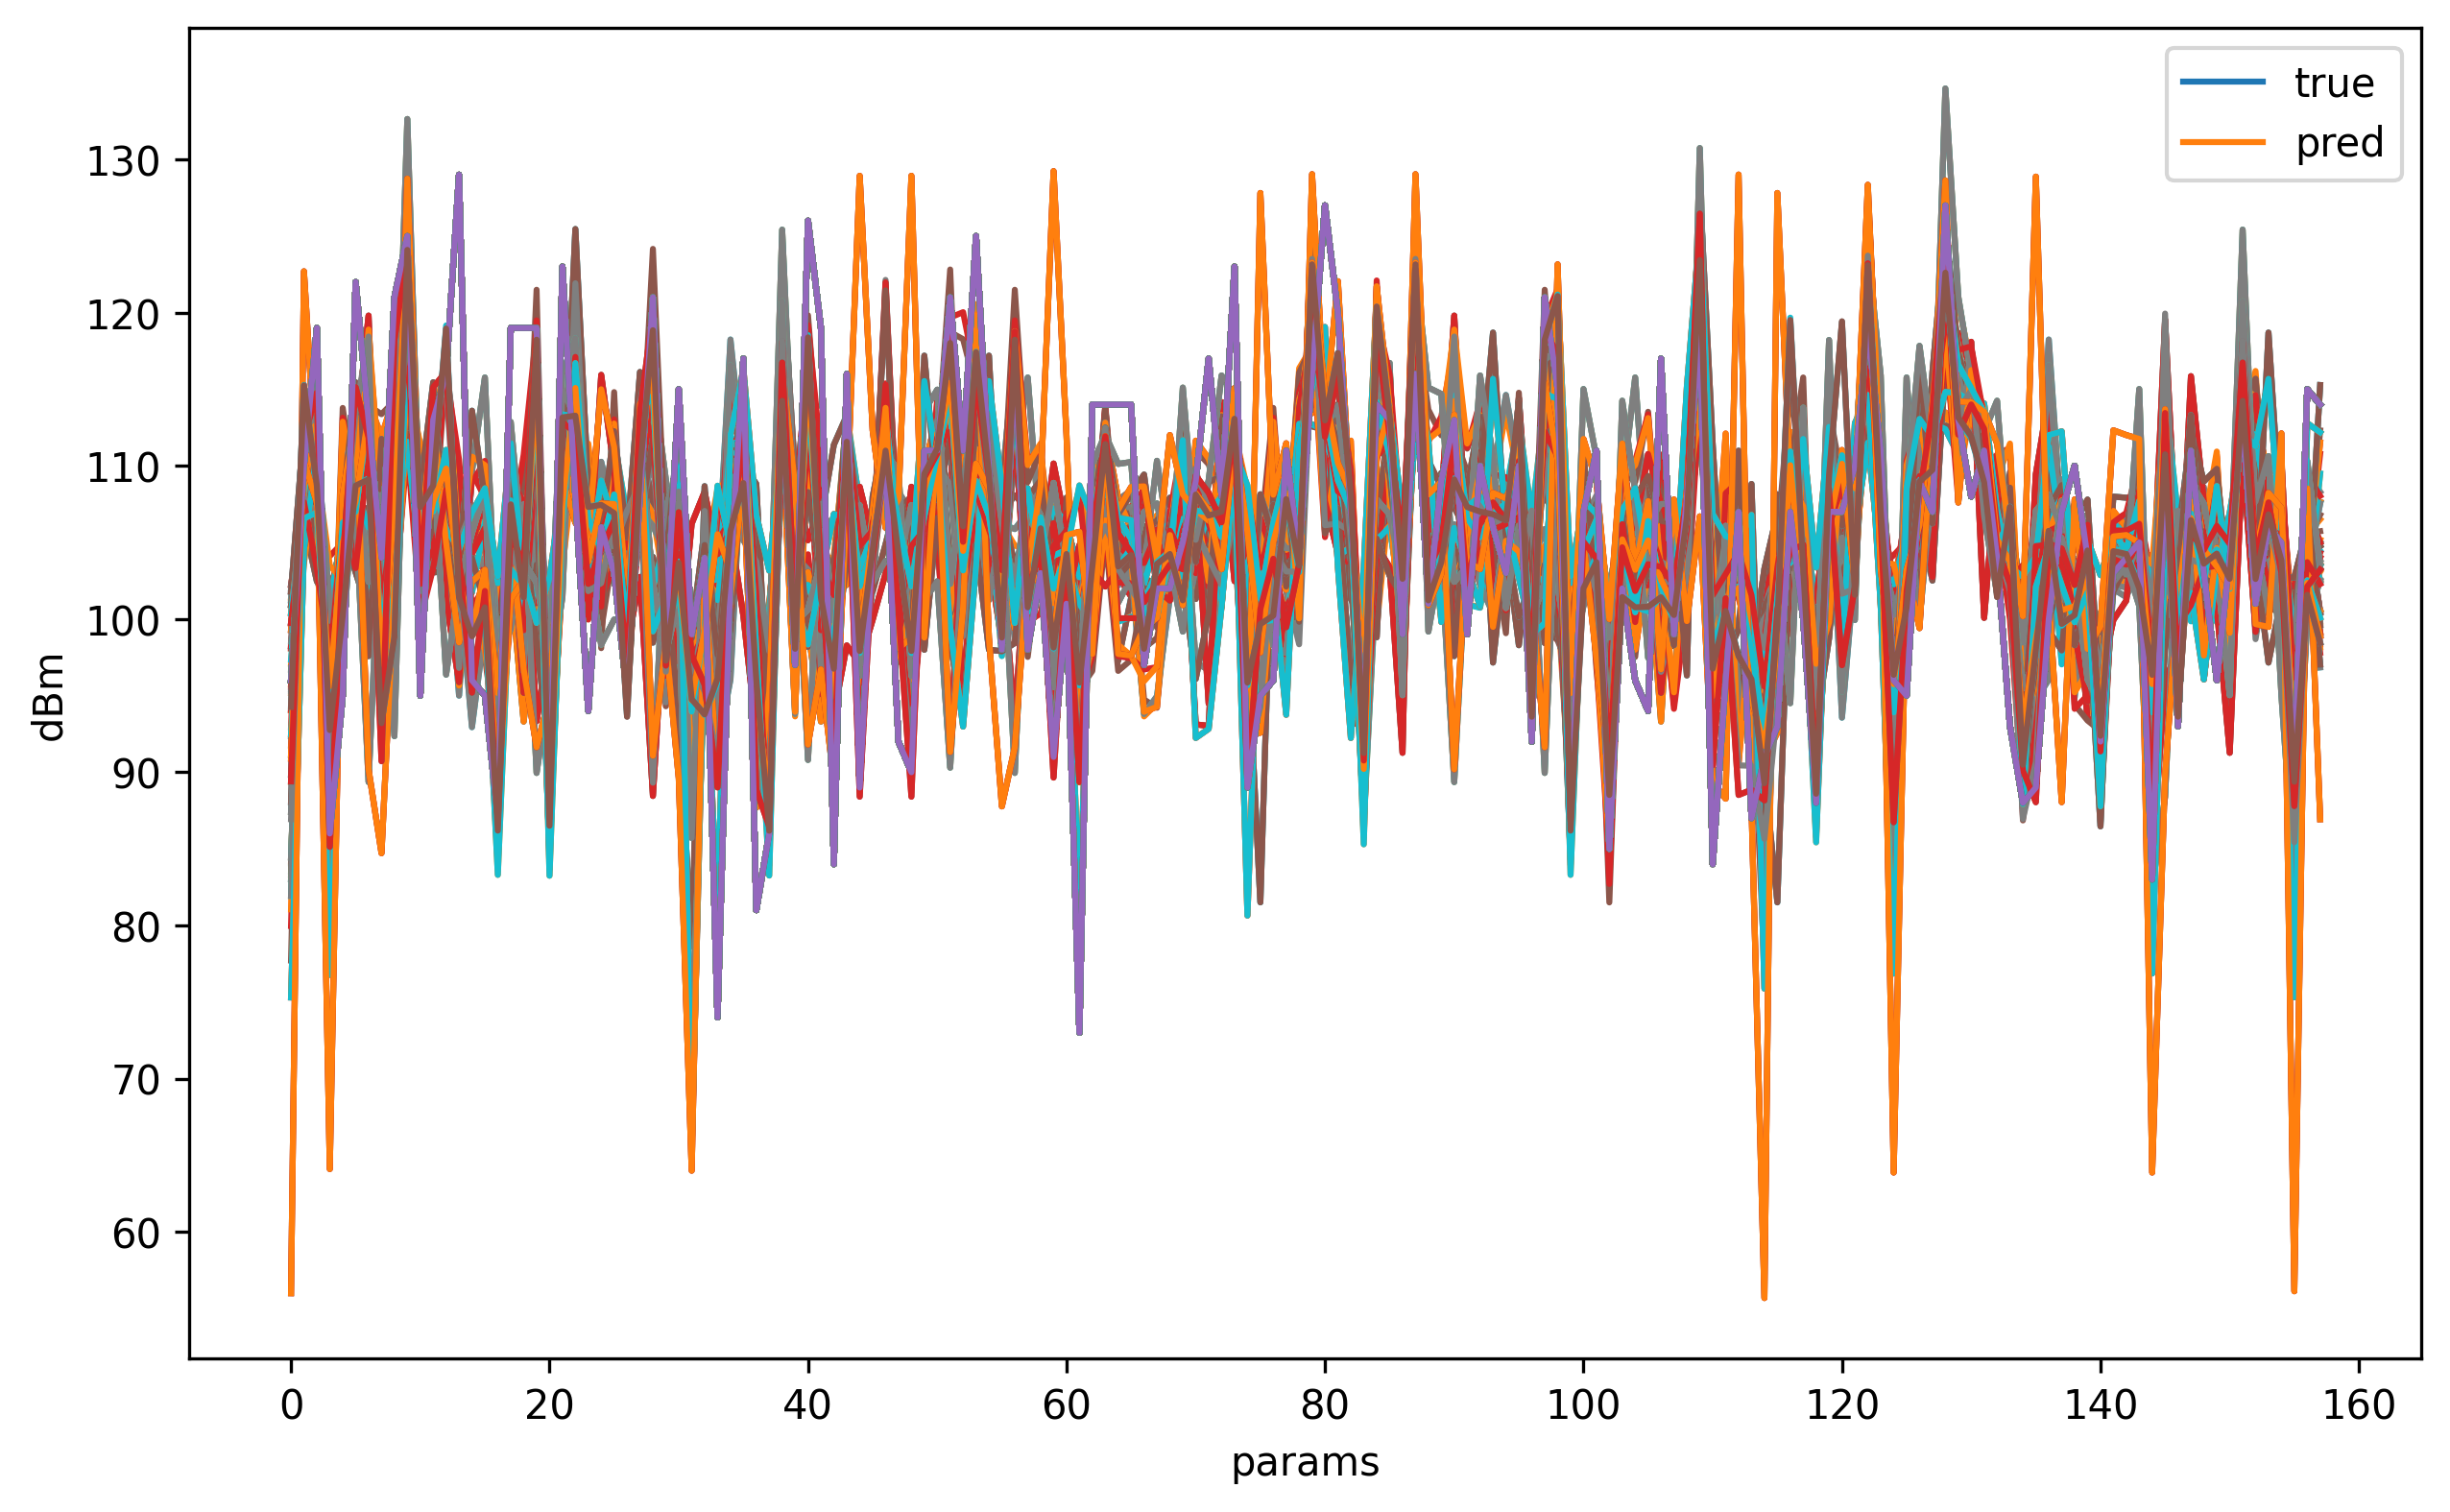

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300


# Store the training and test losses for each grid size for later plotting.
tr_losses = []
te_losses = []
plot_grids = []
plot_steps = []
plot_lambs = []
tr_maes = []
tr_mses = []
tr_mapes = []
tr_r2s = []

train_losses = []
test_losses = []

# Thee parameters for the KAN model.
grids = np.array([5, 8, 10, 15, 20, 30, 40, 50])
steps = np.array([100, 200, 300])
k = 3
lamb = np.array([0.02, 0.002, 0.0002, 0.00002])

for g in range(grids.shape[0]):
    for s in range(steps.shape[0]):
        for l in range(lamb.shape[0]):
            model= KAN(
                width=[3,2,1], 
                grid=grids[g], 
                k=3, 
                seed=42, 
                device=device, 
            ) 
            
            print(f"Grid size: {grids[g]}, steps {steps[s]}, {lamb[l]}")
            results = model.fit(dataset, opt="LBFGS", lamb=lamb[l], steps=steps[s], lamb_entropy=2.)
            
            train_losses += results['train_loss']
            test_losses += results['test_loss']
            #print(np.array(train_losses).mean())

            if not np.isnan(results['train_loss']).any():
                tr_mse, tr_rmse, tr_mae, tr_mape, tr_r2 = eval_kan(model, dataset);
                #te_mse, te_rmse, te_mae, te_mape, te_r2 = eval_kan(model, validation_data);

                plot_grids.append(grids[g])
                plot_steps.append(steps[s])
                plot_lambs.append(lamb[l])
                print(plot_lambs)
                
                tr_losses.append(np.array(train_losses).mean())
                te_losses.append(np.array(test_losses).mean())
                tr_maes.append(tr_mae)
                tr_mses.append(tr_mse)
                tr_mapes.append(tr_mape)
                tr_r2s.append(tr_r2)
